# 1. Load Data

-----

In [1]:
!pip install kagglehub[pandas-datasets]
!pip install pandas as pd
!pip install numpy as np
!pip install matplotlib as plt
!pip install seaborn

ERROR: Could not find a version that satisfies the requirement as (from versions: none)
ERROR: No matching distribution found for as
ERROR: Could not find a version that satisfies the requirement as (from versions: none)
ERROR: No matching distribution found for as
ERROR: Could not find a version that satisfies the requirement as (from versions: none)
ERROR: No matching distribution found for as


- Import the location of the dataset posted on Kaggle:
https://www.kaggle.com/datasets/jonassouza872/vitoria-da-conquista-weather-data-september

In [2]:
import kagglehub
import os
# Store the path of the Kaggle dataset
path = kagglehub.dataset_download("jonassouza872/vitoria-da-conquista-weather-data-september")
# Check if the path is correct
print(path)

# List all files inside the downloaded folder
print(os.listdir(path))

100%|██████████| 1.54M/1.54M [00:00<00:00, 23.9MB/s]

Extracting files...


/root/.cache/kagglehub/datasets/jonassouza872/vitoria-da-conquista-weather-data-september/versions/1
['temp.csv']


In [3]:
import pandas as pd
df = pd.read_csv(f"{path}/temp.csv")  # Reads the declared path as a CSV file
df.head()  # Prints the first 5 rows of the dataset

,Timestamp,Temp_MPU6050_C,Temp_AHT20_C,Umid_AHT20_pct,Temp_BMP280_C,Press_BMP280_hPa,Temp_BMP180_C,Press_BMP180_hPa,Temp_DS18B20_C,Temp_NTC_C,Temp_DHT11_C,Umid_DHT11_pct
0,2025-08-31 22:31:02,20.86,19.90,73.37,21.28,921.24,20.19,923.02,25.69,22.26,20.03,66.0
1,2025-08-31 22:31:33,21.75,19.97,75.57,21.48,921.12,20.27,923.04,23.81,20.73,20.02,66.0
2,2025-08-31 22:32:05,21.80,19.75,74.31,21.25,921.20,20.16,923.06,22.50,20.88,20.02,67.0
3,2025-08-31 22:32:36,21.57,19.55,74.77,21.07,921.15,20.06,922.99,21.31,20.62,20.01,66.0
4,2025-08-31 22:33:07,21.66,19.60,75.09,21.12,921.25,20.06,923.02,21.88,20.95,20.00,66.0


In [4]:
df.columns #all columns

Index(['Timestamp', 'Temp_MPU6050_C', 'Temp_AHT20_C', 'Umid_AHT20_pct',
       'Temp_BMP280_C', 'Press_BMP280_hPa', 'Temp_BMP180_C',
       'Press_BMP180_hPa', 'Temp_DS18B20_C', 'Temp_NTC_C', 'Temp_DHT11_C',
       'Umid_DHT11_pct'],
      dtype='object')

# 2. Anomaly detection

---------------

## 2.1. Z-score-based detection

---

- Task: Identify outliers (extreme values) and flag suspicious readings. Visualize the distribution of anomalies.

The Z-score measures how many standard deviations a data point is away from the mean, calculated as Z = (x - μ)/σ. In anomaly detection, values with |Z| > 3 are typically considered outliers, as they represent extremely rare observations in normal distributions. This method assumes data follows a Gaussian distribution and is sensitive to extreme outliers that can distort the mean and standard deviation. It is a simple and computationally efficient technique, ideal for univariate detection in data that meets the normality assumption.

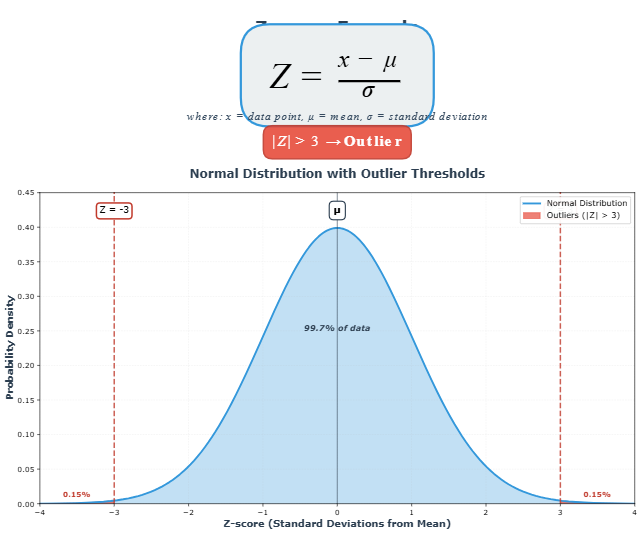

### 2.1.1. Temperature

-------------------

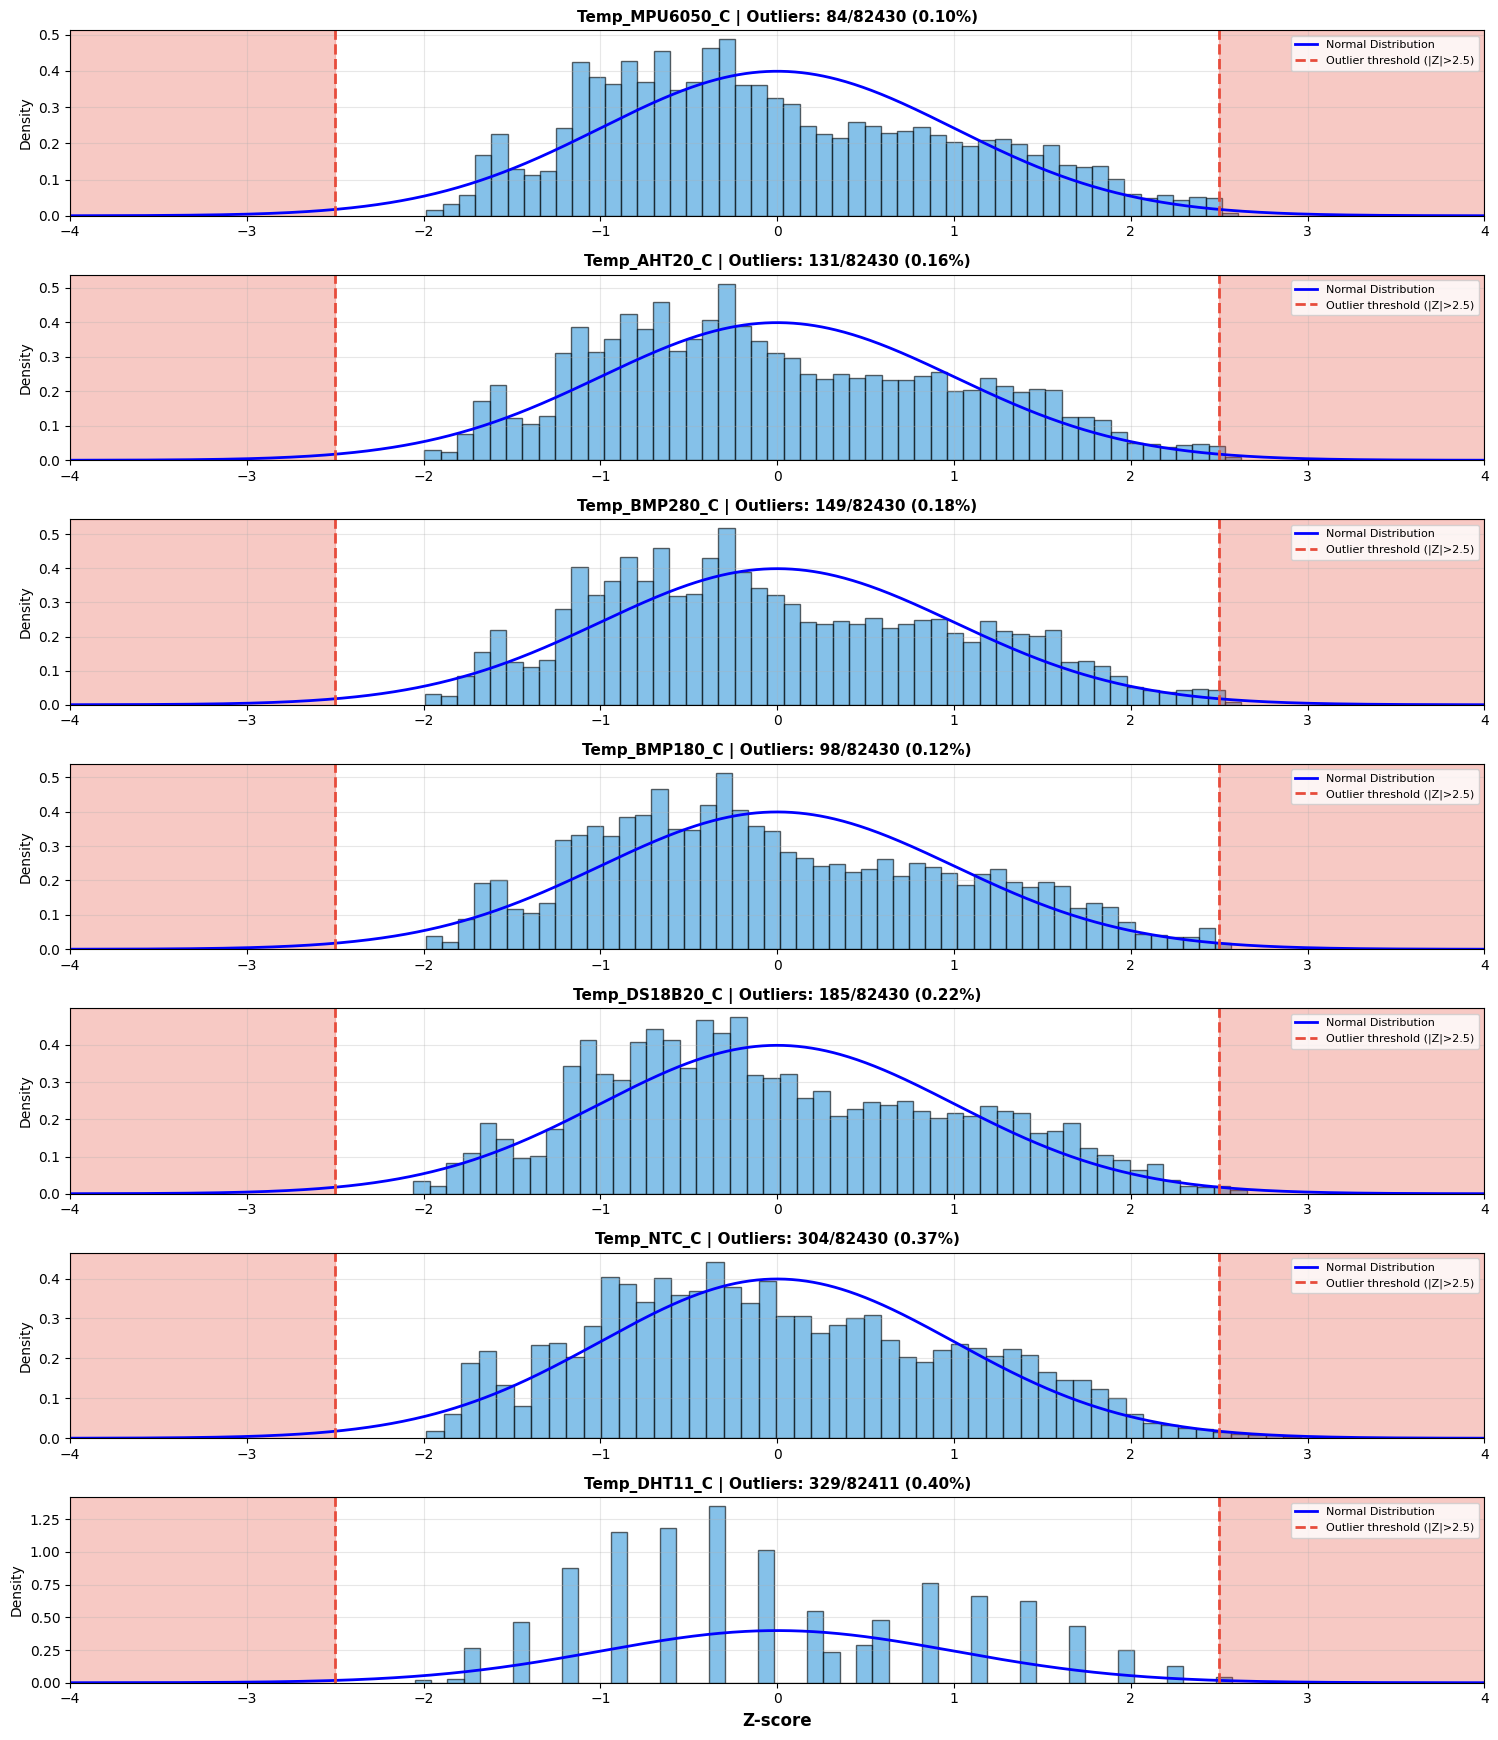

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

temp_sensors = ['Temp_MPU6050_C', 'Temp_AHT20_C', 'Temp_BMP280_C', 'Temp_BMP180_C',
                'Temp_DS18B20_C', 'Temp_NTC_C', 'Temp_DHT11_C'] #all temperature sensors

#Subplots
fig, axes = plt.subplots(len(temp_sensors), 1, figsize=(15, 2.5*len(temp_sensors)), sharex=False)
for idx, sensor in enumerate(temp_sensors): #for each sensor
    z_scores = stats.zscore(df[sensor].dropna()) #calculate z_score
    axes[idx].hist(z_scores, bins=50, alpha=0.6, color='#3498DB', edgecolor='black', density=True)# Plot Z-scores histogram
    x = np.linspace(-4, 4, 1000)
    y = (1/np.sqrt(2*np.pi)) * np.exp(-0.5*x**2)
    axes[idx].plot(x, y, 'b-', linewidth=2, label='Normal Distribution')#Adds normal distribution curve.
    axes[idx].axvline(-2.5, color='#E74C3C', linestyle='--', linewidth=2, label='Outlier threshold (|Z|>2.5)') #Outlier region with z_score > 2.5
    axes[idx].axvline(2.5, color='#E74C3C', linestyle='--', linewidth=2)
    axes[idx].axvspan(-4, -2.5, alpha=0.3, color='#E74C3C')
    axes[idx].axvspan(2.5, 4, alpha=0.3, color='#E74C3C')
    n_outliers = np.sum(np.abs(z_scores) > 2.5) #counts the number of points with a threshold greater than 2.5
    total = len(z_scores) #total data

    axes[idx].set_ylabel('Density', fontsize=10)
    axes[idx].set_title(f'{sensor} | Outliers: {n_outliers}/{total} ({100*n_outliers/total:.2f}%)',  #calculates the % of outliers for each sensor. outlier/total
                      fontsize=11, weight='bold')
    axes[idx].legend(loc='upper right', fontsize=8)
    axes[idx].grid(True, alpha=0.3)
    axes[idx].set_xlim(-4, 4)

plt.xlabel('Z-score', fontsize=12, weight='bold')
plt.tight_layout()
plt.show()

Initially, no outliers were detected using the standard threshold of |Z| > 3, indicating that the sensors operate stably and consistently. For a more sensitive analysis, the threshold was reduced to |Z| > 2.5, which flags data points beyond 2.5 standard deviations from the mean—capturing approximately 1.24% of data in a normal distribution compared to only 0.27% with |Z| > 3. This revealed small proportions of outliers: MPU6050 (0.10%), AHT20 (0.16%), BMP280 (0.18%), BMP180 (0.12%), DS18B20 (0.22%), NTC (0.37%), and DHT11 (0.40%). The NTC and DHT11 sensors show the highest outlier rates, suggesting greater variability or sensitivity to noise, while the others maintain excellent conformity with the expected normal distribution. Most distributions closely approximate the theoretical Gaussian curve, confirming the quality and reliability of the collected data.

### 2.1.2. Humidity

---------

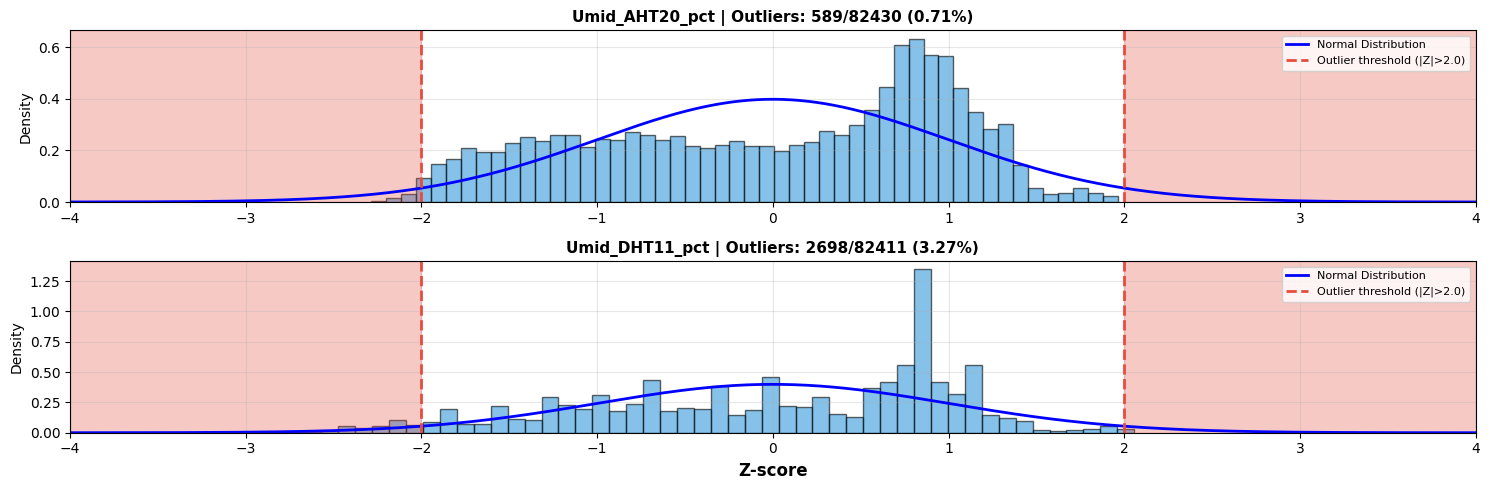

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

humidity_sensors = [
    'Umid_AHT20_pct',
    'Umid_DHT11_pct'
] #all humidity sensors

#Subplots
fig, axes = plt.subplots(len(humidity_sensors), 1, figsize=(15, 2.5*len(humidity_sensors)), sharex=False)

# Handle the case of a single sensor (where 'axes' is not an array)
if len(humidity_sensors) == 1:
    axes = [axes]

for idx, sensor in enumerate(humidity_sensors): #for each sensor
    z_scores = stats.zscore(df[sensor].dropna()) #calculate z_score
    axes[idx].hist(z_scores, bins=50, alpha=0.6, color='#3498DB', edgecolor='black', density=True)# Plot Z-scores histogram
    x = np.linspace(-4, 4, 1000)
    y = (1/np.sqrt(2*np.pi)) * np.exp(-0.5*x**2)
    axes[idx].plot(x, y, 'b-', linewidth=2, label='Normal Distribution')#Adds normal distribution curve.
    axes[idx].axvline(-2.0, color='#E74C3C', linestyle='--', linewidth=2, label='Outlier threshold (|Z|>2.0)') #Outlier region with z_score > 2.0
    axes[idx].axvline(2.0, color='#E74C3C', linestyle='--', linewidth=2)
    axes[idx].axvspan(-4, -2.0, alpha=0.3, color='#E74C3C')
    axes[idx].axvspan(2.0, 4, alpha=0.3, color='#E74C3C')
    n_outliers = np.sum(np.abs(z_scores) > 2.0) #counts the number of points with a threshold greater than 2.0
    total = len(z_scores) #total data

    axes[idx].set_ylabel('Density', fontsize=10)
    axes[idx].set_title(f'{sensor} | Outliers: {n_outliers}/{total} ({100*n_outliers/total:.2f}%)',  #calculates the % of outliers for each sensor. outlier/total
                      fontsize=11, weight='bold')
    axes[idx].legend(loc='upper right', fontsize=8)
    axes[idx].grid(True, alpha=0.3)
    axes[idx].set_xlim(-4, 4)

plt.xlabel('Z-score', fontsize=12, weight='bold')
plt.tight_layout()
plt.show()

Due to the absence of outliers with higher thresholds, the limit was reduced to |Z| > 2.0, which captures approximately 4.55% of data in a normal distribution (compared to 1.24% with |Z| > 2.5). The AHT20 sensor showed only 0.71% outliers, demonstrating excellent stability and strong conformity with the expected Gaussian distribution, with data well concentrated near the mean. In contrast, the DHT11 sensor exhibited 3.27% outliers, indicating greater variability and significant deviation from the theoretical normal curve, with a more dispersed and asymmetric distribution. The marked difference between sensors suggests that the DHT11 is more susceptible to noise and environmental fluctuations, while the AHT20 offers more consistent and reliable measurements for humidity monitoring.

### 2.1.3. Pressure

------------------------

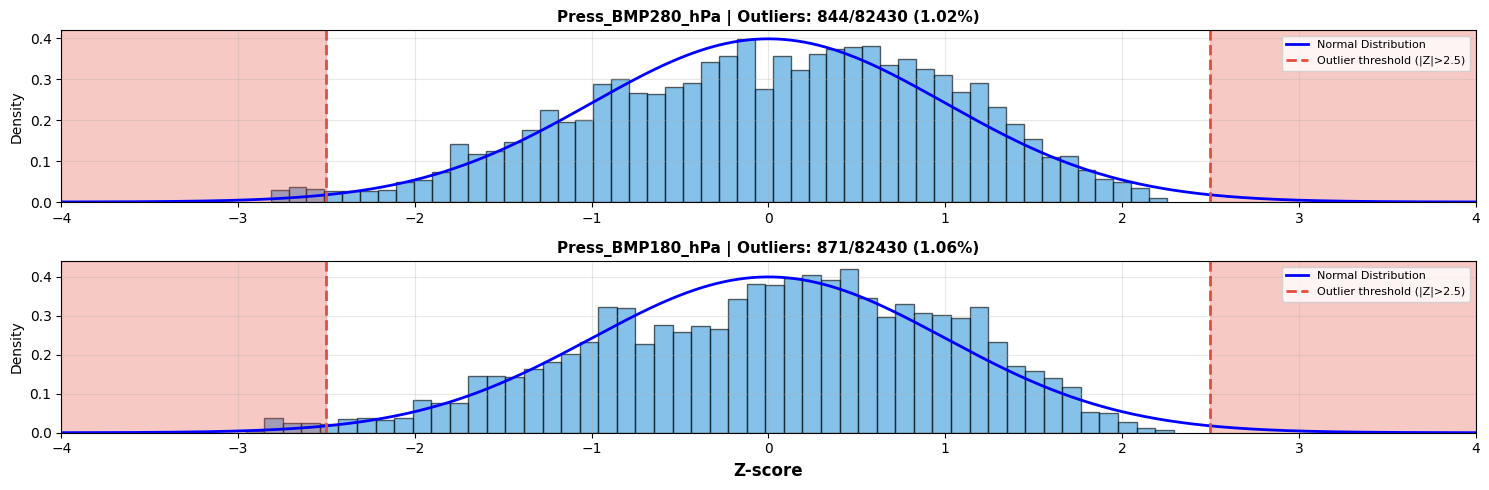

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

pressure_sensors = [
    'Press_BMP280_hPa',
    'Press_BMP180_hPa'
] #all pressure sensors

#Subplots
fig, axes = plt.subplots(len(pressure_sensors), 1, figsize=(15, 2.5*len(pressure_sensors)), sharex=False)

# Handle the case of a single sensor (where 'axes' is not an array)
if len(pressure_sensors) == 1:
    axes = [axes]

for idx, sensor in enumerate(pressure_sensors): #for each sensor
    z_scores = stats.zscore(df[sensor].dropna()) #calculate z_score
    axes[idx].hist(z_scores, bins=50, alpha=0.6, color='#3498DB', edgecolor='black', density=True)# Plot Z-scores histogram
    x = np.linspace(-4, 4, 1000)
    y = (1/np.sqrt(2*np.pi)) * np.exp(-0.5*x**2)
    axes[idx].plot(x, y, 'b-', linewidth=2, label='Normal Distribution')#Adds normal distribution curve.
    axes[idx].axvline(-2.5, color='#E74C3C', linestyle='--', linewidth=2, label='Outlier threshold (|Z|>2.5)') #Outlier region with z_score > 2.5
    axes[idx].axvline(2.5, color='#E74C3C', linestyle='--', linewidth=2)
    axes[idx].axvspan(-4, -2.5, alpha=0.3, color='#E74C3C')
    axes[idx].axvspan(2.5, 4, alpha=0.3, color='#E74C3C')
    n_outliers = np.sum(np.abs(z_scores) > 2.5) #counts the number of points with a threshold greater than 2.5
    total = len(z_scores) #total data

    axes[idx].set_ylabel('Density', fontsize=10)
    axes[idx].set_title(f'{sensor} | Outliers: {n_outliers}/{total} ({100*n_outliers/total:.2f}%)',  #calculates the % of outliers for each sensor. outlier/total
                      fontsize=11, weight='bold')
    axes[idx].legend(loc='upper right', fontsize=8)
    axes[idx].grid(True, alpha=0.3)
    axes[idx].set_xlim(-4, 4)

plt.xlabel('Z-score', fontsize=12, weight='bold')
plt.tight_layout()
plt.show()

Both pressure sensors demonstrated exceptional performance with the threshold of |Z| > 2.5, which captures approximately 1.24% of data in a normal distribution. The BMP280 sensor exhibited 1.02% outliers while the BMP180 showed 1.06% outliers, indicating nearly identical and highly stable behavior between both devices. Both distributions closely follow the theoretical Gaussian curve with data well centered around the mean, demonstrating excellent measurement consistency and minimal noise interference. The remarkably similar outlier rates and distribution patterns suggest that both barometric pressure sensors are operating reliably under the same environmental conditions, with no significant calibration drift or sensor-specific anomalies detected during the monitoring period.

## 2.2. Isolation Forest

------------------

Isolation Forest is an anomaly detection algorithm based on decision trees that isolates outliers through random partitions of the data space. The fundamental principle is that anomalies are rare and distinct points, therefore requiring fewer splits (lower tree depth) to be isolated compared to normal points. The algorithm calculates an "anomaly score" for each observation, where values close to 1 indicate anomalies and values close to 0 indicate normal data. It is computationally efficient, does not require data normalization, works well in high dimensions, and detects global anomalies without assuming any specific data distribution.

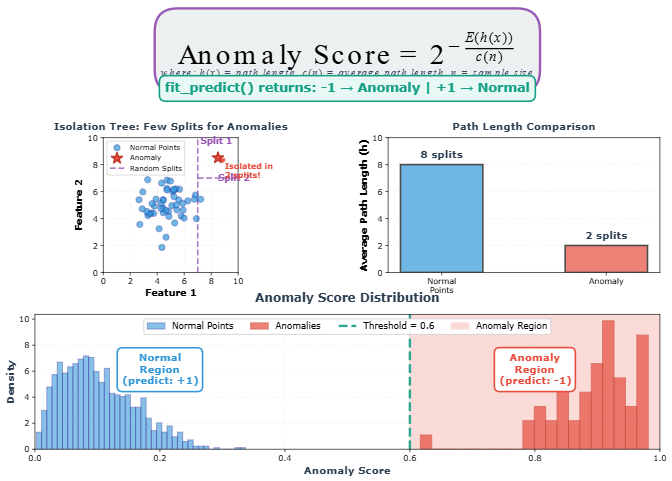

The anomaly score equation s(x, n) = 2^(-E(h(x))/c(n)) normalizes the average path length E(h(x)) of a data point across all isolation trees by dividing it by c(n), the expected path length for a dataset of size n. The normalization factor c(n) = 2H(n-1) - 2(n-1)/n (where H is the harmonic number) represents the average path length of an unsuccessful search in a binary search tree, providing a baseline for comparison. Points with shorter path lengths (isolated quickly) receive scores closer to 1 (anomalies), while points requiring many splits to isolate receive scores closer to 0 (normal points), with scores around 0.5 indicating no clear distinction.

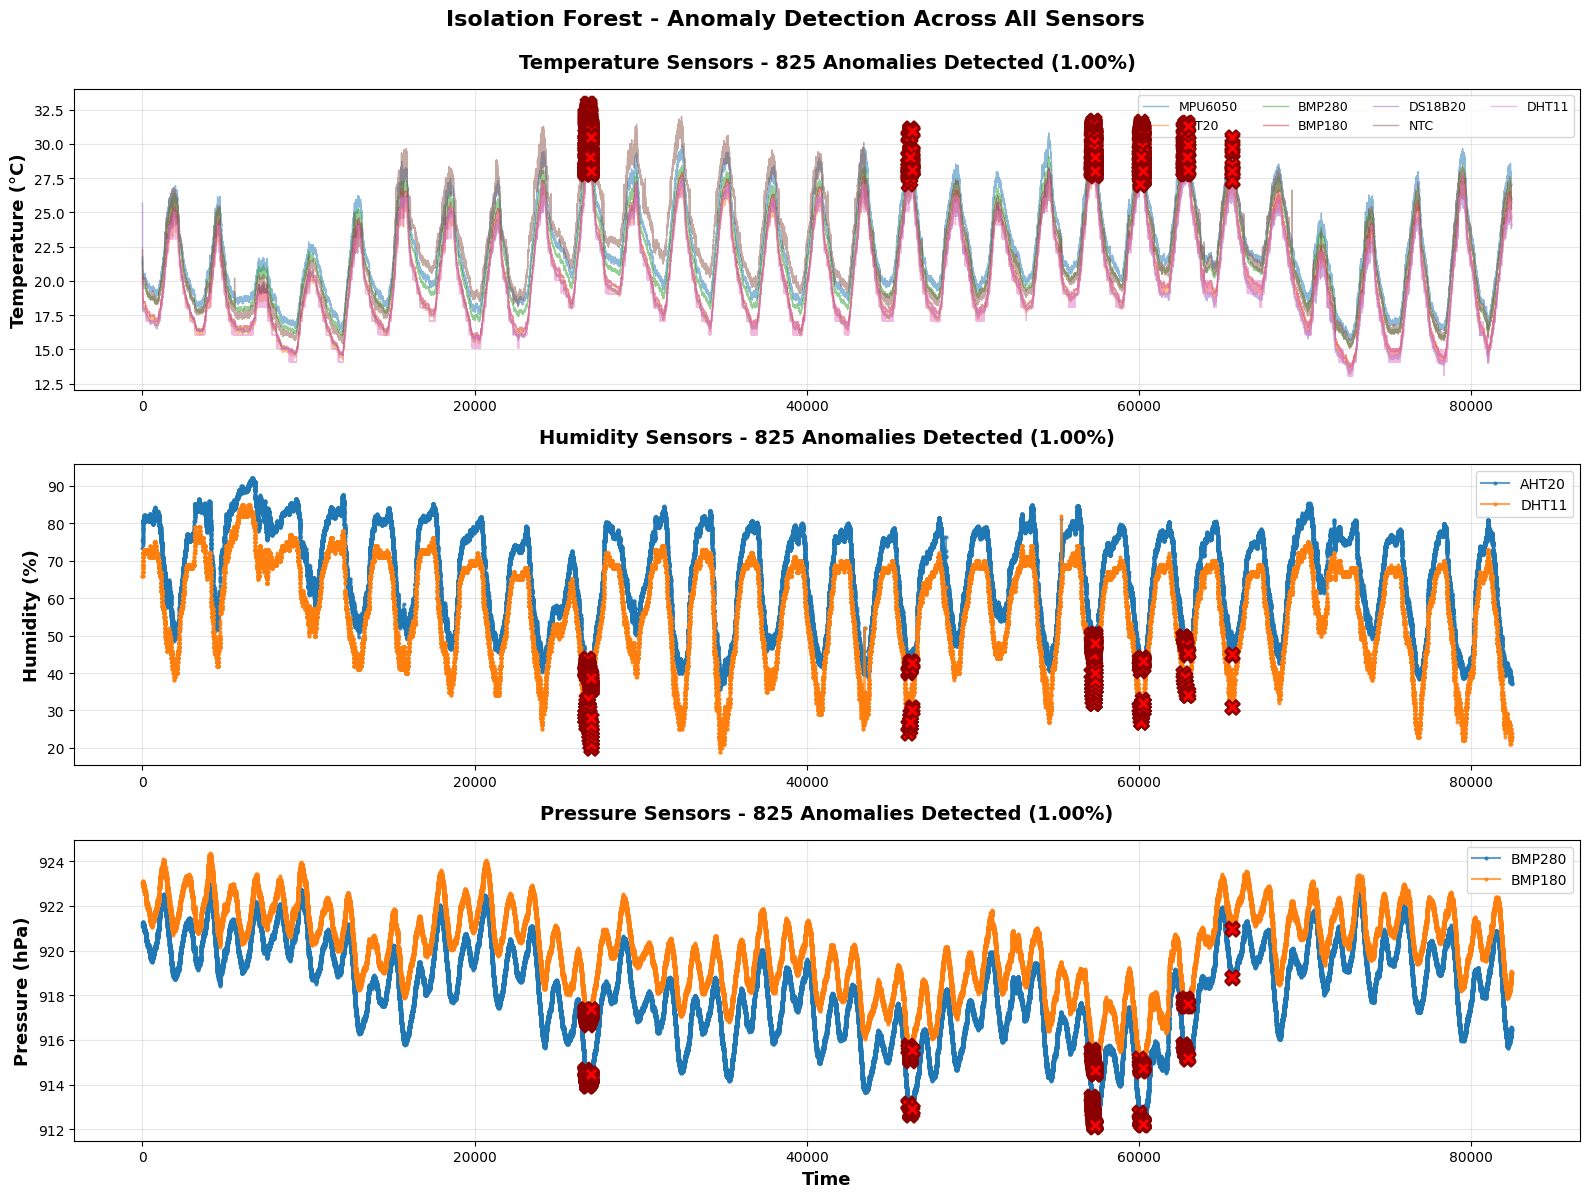

In [27]:
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

temp_sensors = ['Temp_MPU6050_C', 'Temp_AHT20_C', 'Temp_BMP280_C', 'Temp_BMP180_C',
                'Temp_DS18B20_C', 'Temp_NTC_C', 'Temp_DHT11_C'] #all temperature sensors
humidity_sensors = ['Umid_AHT20_pct', 'Umid_DHT11_pct'] #all humidity sensors
pressure_sensors = ['Press_BMP280_hPa', 'Press_BMP180_hPa'] #all pressure sensors

all_sensors = temp_sensors + humidity_sensors + pressure_sensors #all sensors
features = df[all_sensors].dropna() #remove invalid data
iso_forest = IsolationForest(contamination=0.01, random_state=42, n_estimators=200) #train isolation forest model with 200 samples
predictions = iso_forest.fit_predict(features) #make predictions from the 200 samples
df.loc[features.index, 'IF_anomaly'] = predictions
n_anomalies = (predictions == -1).sum()
n_total = len(predictions) #total data
anomaly_percentage = 100 * n_anomalies / n_total

fig, axes = plt.subplots(3, 1, figsize=(16, 12)) #temperature time series
ax1 = axes[0]
for sensor in temp_sensors: #for temperature
    ax1.plot(df.index, df[sensor], alpha=0.5, linewidth=1, label=sensor.replace('Temp_', '').replace('_C', ''))
anomalies = df[df['IF_anomaly'] == -1]
# Highlight anomalies
for sensor in temp_sensors:
    ax1.scatter(anomalies.index, anomalies[sensor], c='red', s=100,
               marker='X', zorder=10, edgecolors='darkred', linewidth=1.5)
ax1.set_ylabel('Temperature (°C)', fontsize=13, weight='bold')
ax1.set_title(f'Temperature Sensors - {n_anomalies} Anomalies Detected ({anomaly_percentage:.2f}%)',
             fontsize=14, weight='bold', pad=15)
ax1.legend(loc='upper right', fontsize=9, ncol=4)
ax1.grid(True, alpha=0.3)

ax2 = axes[1]
for sensor in humidity_sensors: #for humidity
    ax2.plot(df.index, df[sensor], alpha=0.7, linewidth=1.5,
            label=sensor.replace('Umid_', '').replace('_pct', ''), marker='o', markersize=2)
for sensor in humidity_sensors:
    ax2.scatter(anomalies.index, anomalies[sensor], c='red', s=100,
               marker='X', zorder=10, edgecolors='darkred', linewidth=1.5)
ax2.set_ylabel('Humidity (%)', fontsize=13, weight='bold')
ax2.set_title(f'Humidity Sensors - {n_anomalies} Anomalies Detected ({anomaly_percentage:.2f}%)',
             fontsize=14, weight='bold', pad=15)
ax2.legend(loc='upper right', fontsize=10)
ax2.grid(True, alpha=0.3)

ax3 = axes[2]
for sensor in pressure_sensors: #for pressure
    ax3.plot(df.index, df[sensor], alpha=0.7, linewidth=1.5,
            label=sensor.replace('Press_', '').replace('_hPa', ''), marker='o', markersize=2)
for sensor in pressure_sensors:
    ax3.scatter(anomalies.index, anomalies[sensor], c='red', s=100,
               marker='X', zorder=10, edgecolors='darkred', linewidth=1.5)
ax3.set_xlabel('Time', fontsize=13, weight='bold')
ax3.set_ylabel('Pressure (hPa)', fontsize=13, weight='bold')
ax3.set_title(f'Pressure Sensors - {n_anomalies} Anomalies Detected ({anomaly_percentage:.2f}%)',
             fontsize=14, weight='bold', pad=15)
ax3.legend(loc='upper right', fontsize=10)
ax3.grid(True, alpha=0.3)

plt.suptitle(f'Isolation Forest - Anomaly Detection Across All Sensors',
            fontsize=16, weight='bold', y=0.995)
plt.tight_layout()
plt.show()

The Isolation Forest detected 825 anomalies (approximately 1% of the data) distributed throughout the entire monitoring period, revealing interesting multimodal patterns. Temperature anomalies concentrate primarily at the maximum peaks of cyclic oscillations (aprox 32°C), suggesting the algorithm identifies extreme value combinations as anomalous behaviors. In humidity sensors, anomalies appear predominantly during sharp drops (aprox 20-40%), indicating that these rapid transitions are considered unusual by the model when analyzed together with other sensors. For pressure, anomalies are detected in both valleys (aprox 912-914 hPa) and some peaks, demonstrating that the algorithm captures multivariate deviations even when individual values seem reasonable, confirming the strength of Isolation Forest's multidimensional analysis.

- Use PCA

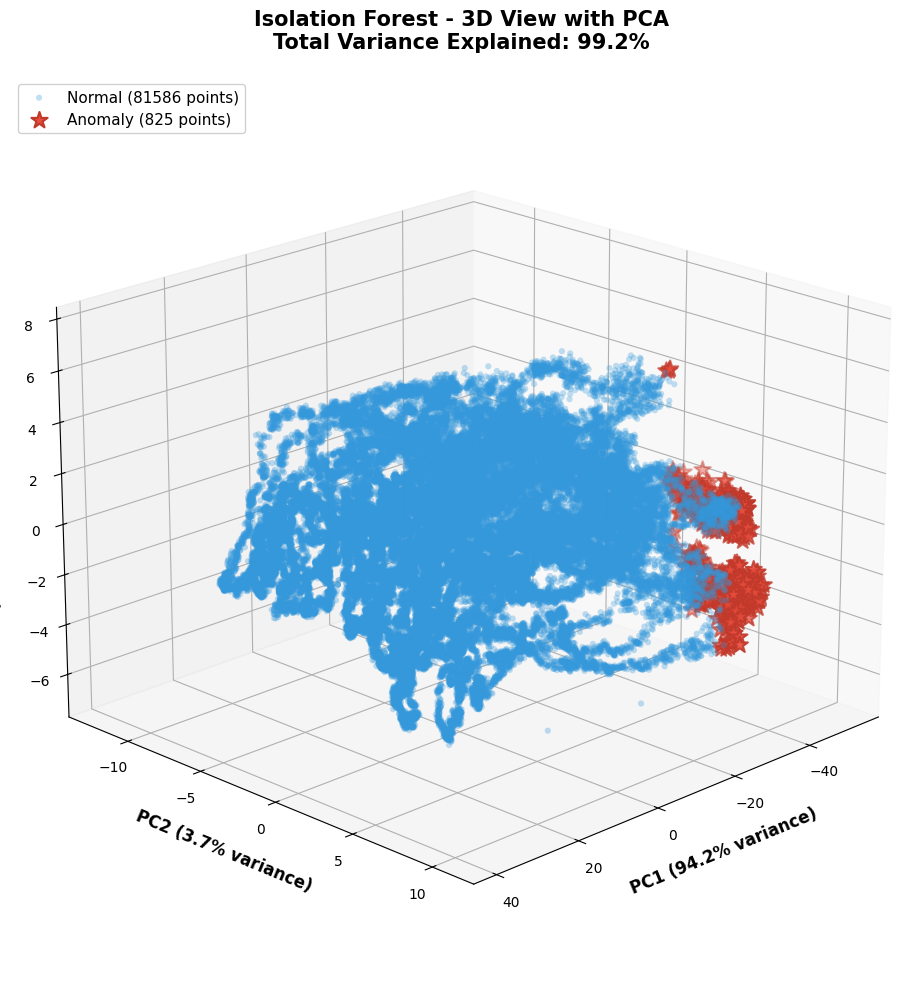

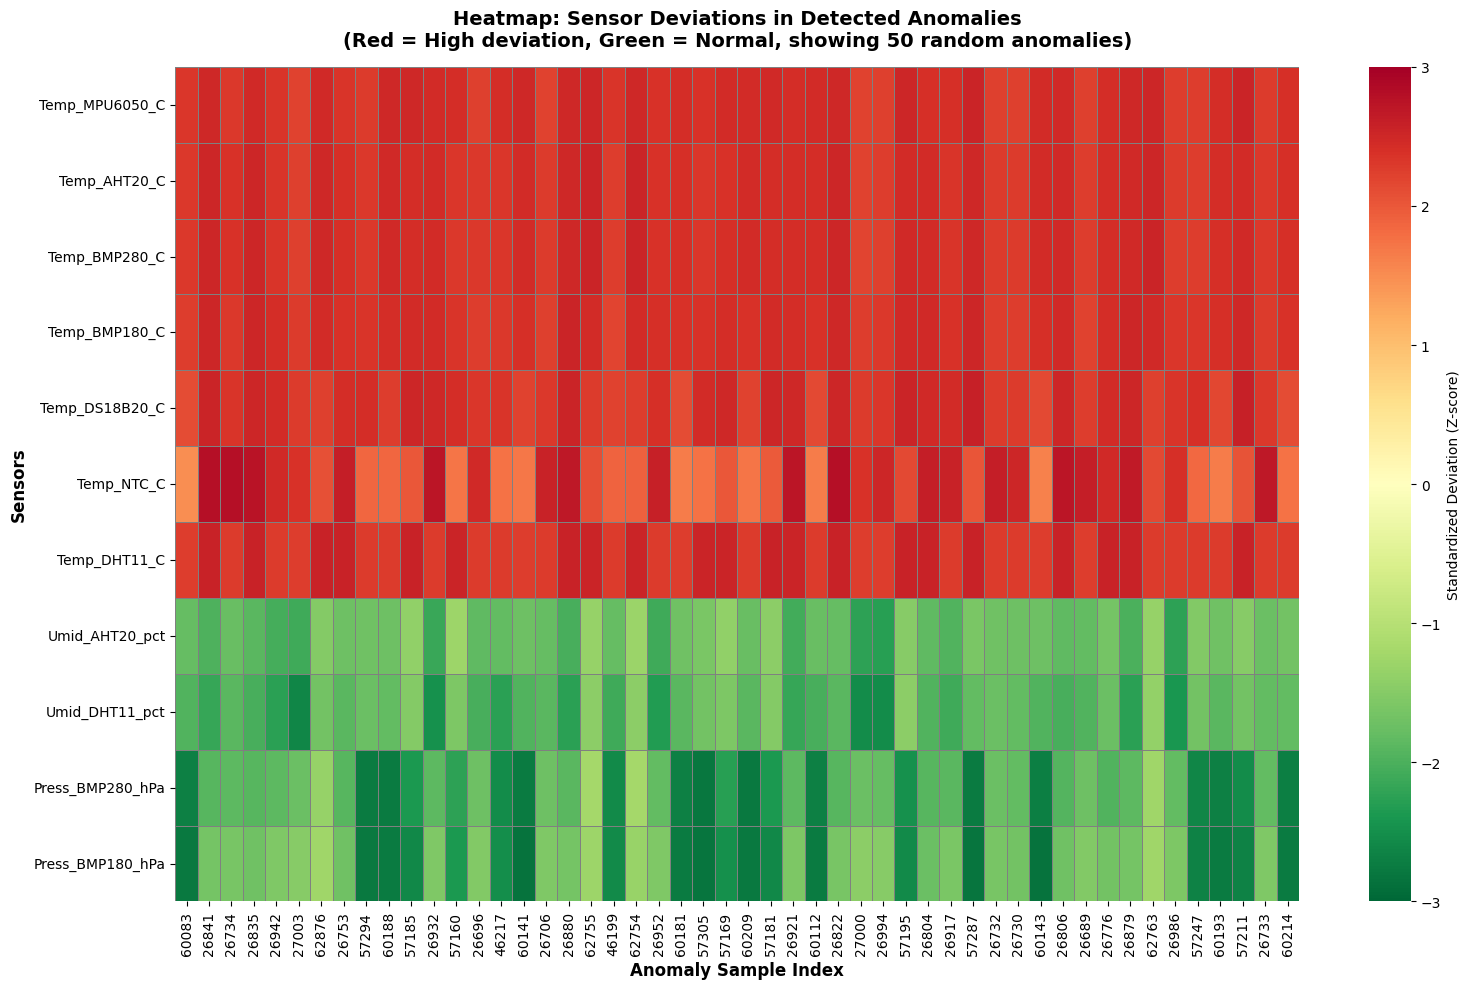

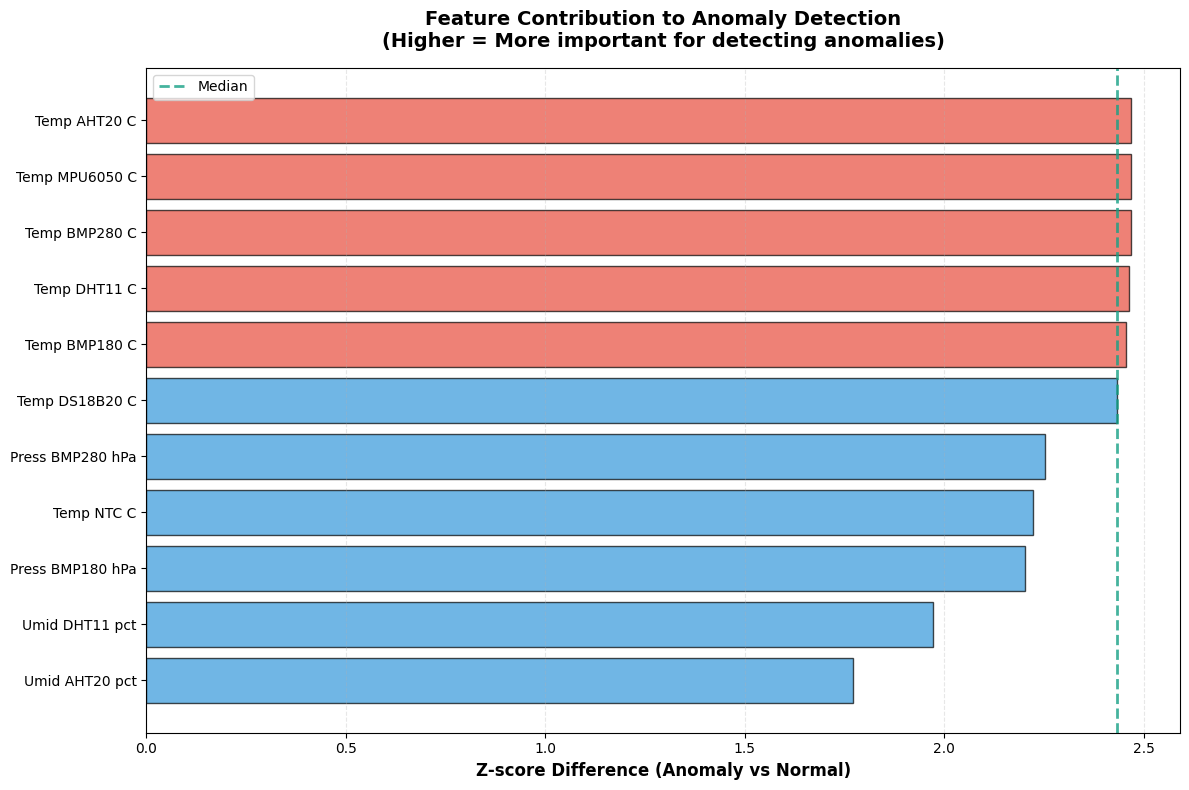

In [32]:
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import numpy as np
import seaborn as sns

pca = PCA(n_components=3) # Reduce to 3 dimensions
features_pca = pca.fit_transform(features) #reduce features from 11 dimensions to 3
normal_mask = predictions == 1 # Separate normal
anomaly_mask = predictions == -1 # separate anomalies

# Create 3D figure
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(features_pca[normal_mask, 0],  #plot normal
          features_pca[normal_mask, 1],
          features_pca[normal_mask, 2],
          c='#3498DB', alpha=0.3, s=20,
          label=f'Normal ({normal_mask.sum()} points)',
          edgecolors='none')
ax.scatter(features_pca[anomaly_mask, 0],  #plot anomalies
          features_pca[anomaly_mask, 1],
          features_pca[anomaly_mask, 2],
          c='#E74C3C', s=150, marker='*',
          label=f'Anomaly ({anomaly_mask.sum()} points)',
          edgecolors='#C0392B', linewidth=1.5, zorder=5)
ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)',
              fontsize=12, weight='bold', labelpad=10)
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)',
              fontsize=12, weight='bold', labelpad=10)
ax.set_zlabel(f'PC3 ({pca.explained_variance_ratio_[2]:.1%} variance)',
              fontsize=12, weight='bold', labelpad=10)
ax.set_title(f'Isolation Forest - 3D View with PCA\nTotal Variance Explained: {pca.explained_variance_ratio_.sum():.1%}',  #title
             fontsize=15, weight='bold', pad=20)
ax.legend(loc='upper left', fontsize=11, framealpha=0.9)
ax.grid(True, alpha=0.3)
ax.view_init(elev=20, azim=45)
plt.tight_layout()
plt.show()

# Normalize data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)#normalize data
features_scaled_df = pd.DataFrame(features_scaled, columns=all_sensors, index=features.index)

# Get only anomalies (limit to 50 for visualization)
anomalies_all = features_scaled_df[predictions == -1]
if len(anomalies_all) >= 50:
    anomalies_scaled = anomalies_all.sample(n=50, random_state=42)
else:
    anomalies_scaled = anomalies_all

fig, ax = plt.subplots(figsize=(16, 10))
#ploat heatmap
sns.heatmap(anomalies_scaled.T, cmap='RdYlGn_r', center=0,
           cbar_kws={'label': 'Standardized Deviation (Z-score)'},
           linewidths=0.5, linecolor='gray', vmin=-3, vmax=3)
plt.title('Heatmap: Sensor Deviations in Detected Anomalies\n(Red = High deviation, Green = Normal, showing 50 random anomalies)',
         fontsize=14, weight='bold', pad=15)
plt.xlabel('Anomaly Sample Index', fontsize=12, weight='bold')
plt.ylabel('Sensors', fontsize=12, weight='bold')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Calculate differences between normal and anomalies
anomalies_df = features[predictions == -1]
normal_df = features[predictions == 1]
feature_comparison = pd.DataFrame({
    'Normal_Mean': normal_df.mean(),
    'Normal_Std': normal_df.std(),
    'Anomaly_Mean': anomalies_df.mean(),
    'Anomaly_Std': anomalies_df.std(),
    'Abs_Difference': abs(anomalies_df.mean() - normal_df.mean())
})

feature_comparison['Z_Difference'] = feature_comparison['Abs_Difference'] / feature_comparison['Normal_Std']
feature_comparison = feature_comparison.sort_values('Z_Difference', ascending=True)

# Plot
fig, ax = plt.subplots(figsize=(12, 8))

colors = ['#E74C3C' if val > feature_comparison['Z_Difference'].median() else '#3498DB'
          for val in feature_comparison['Z_Difference'].values]
bars = ax.barh(range(len(feature_comparison)), feature_comparison['Z_Difference'].values,
              color=colors, alpha=0.7, edgecolor='black', linewidth=1)
ax.set_yticks(range(len(feature_comparison)))
ax.set_yticklabels([s.replace('_', ' ') for s in feature_comparison.index], fontsize=10)
ax.set_xlabel('Z-score Difference (Anomaly vs Normal)', fontsize=12, weight='bold')
ax.set_title('Feature Contribution to Anomaly Detection\n(Higher = More important for detecting anomalies)',
            fontsize=14, weight='bold', pad=15)
ax.grid(axis='x', alpha=0.3, linestyle='--')
ax.axvline(feature_comparison['Z_Difference'].median(), color='#16A085',
          linestyle='--', linewidth=2, alpha=0.8, label='Median')
ax.legend(fontsize=10)
plt.tight_layout()
plt.show()

PCA (Principal Component Analysis) reduced the 11 original dimensions (7 temperature sensors, 2 humidity sensors, and 2 pressure sensors) to only 3 principal components, enabling 3D visualization of multidimensional data. The three components capture 99.2% of the total variance from the original data, meaning that almost all relevant information was preserved even after the drastic dimensionality reduction. Each principal component is a linear combination of the original variables that maximizes explained variance, with PC1 accounting for 94.2% (the direction of greatest variation in the data), PC2 for 3.7%, and PC3 for 1.3%. The resulting 3D plot clearly shows that anomalies (red stars) form a distinct cluster separated from the mass of normal data (blue points), visually validating the effectiveness of Isolation Forest in detecting anomalous patterns in the reduced space.

The Isolation Forest algorithm successfully detected 825 anomalies (1% of 82,430 samples) across all 11 sensor features, demonstrating effective multivariate anomaly detection. Temperature sensors dominated anomaly detection with the highest contribution (~2.5 Z-score difference), where all seven temperature sensors showed consistently elevated values during anomalous events, indicating that thermal extremes are the primary anomaly driver. The heatmap reveals a clear pattern: anomalies occur when temperature sensors simultaneously deviate upward (red zones) while humidity sensors deviate downward (green zones), representing rare hot-and-dry environmental conditions. Pressure sensors showed moderate contribution with slight negative deviations, supporting the temperature-humidity pattern but playing a secondary role in anomaly identification. The PCA 3D visualization confirmed the algorithm's effectiveness by showing anomalies as a distinct cluster separated from normal data, with 99.2% variance captured in three dimensions, validating that the detected anomalies represent genuinely unusual multivariate patterns rather than random noise or single-sensor errors.

## 2.3. Fault Detection in Sensors

-----------

### 2.3.1. Temperature:

STUCK VALUES ANALYSIS (Δ < 0.01°C)
Temp_MPU6050_C      :  16643 (20.19%)
Temp_AHT20_C        :  13425 (16.29%)
Temp_BMP280_C       :  14443 (17.52%)
Temp_BMP180_C       :  24149 (29.30%)
Temp_DS18B20_C      :  48939 (59.37%)
Temp_NTC_C          :   4996 ( 6.06%)
Temp_DHT11_C        :  46722 (56.68%)


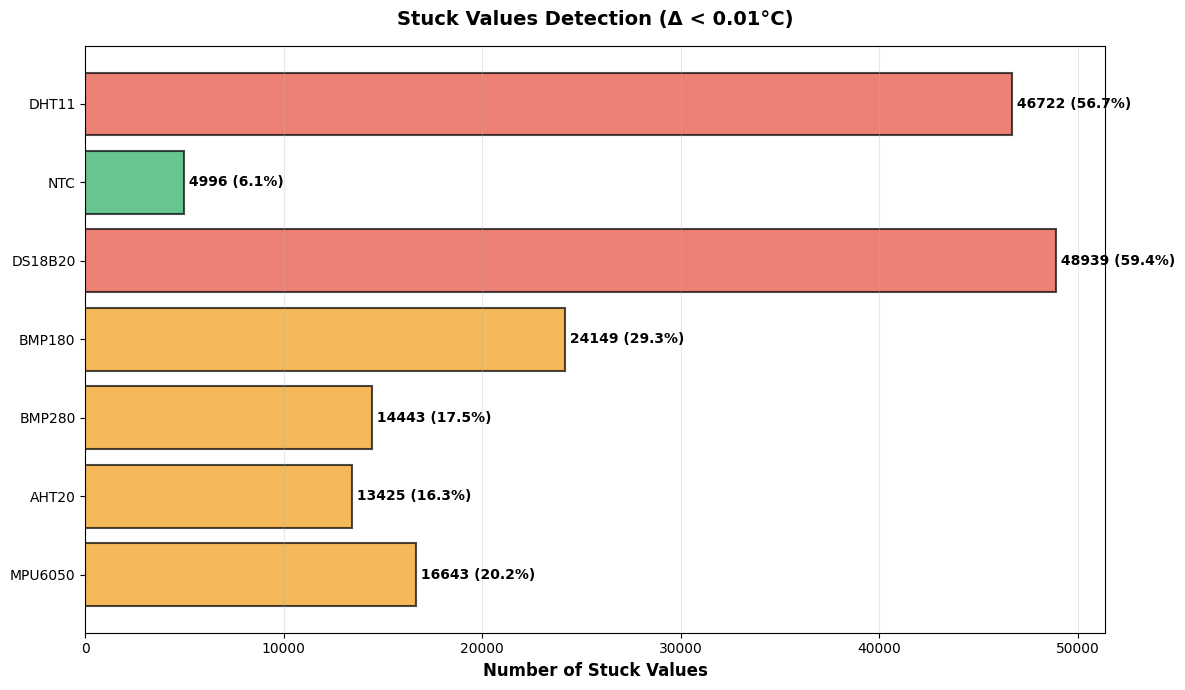


ABRUPT JUMPS ANALYSIS (Δ > 5°C)
Temp_MPU6050_C      :      0 ( 0.00%)
Temp_AHT20_C        :      0 ( 0.00%)
Temp_BMP280_C       :      0 ( 0.00%)
Temp_BMP180_C       :      0 ( 0.00%)
Temp_DS18B20_C      :      0 ( 0.00%)
Temp_NTC_C          :      0 ( 0.00%)
Temp_DHT11_C        :      0 ( 0.00%)

OUT OF RANGE ANALYSIS (T < 10°C or T > 40°C)
Temp_MPU6050_C      :      0 ( 0.00%)
Temp_AHT20_C        :      0 ( 0.00%)
Temp_BMP280_C       :      0 ( 0.00%)
Temp_BMP180_C       :      0 ( 0.00%)
Temp_DS18B20_C      :      0 ( 0.00%)
Temp_NTC_C          :      0 ( 0.00%)
Temp_DHT11_C        :      0 ( 0.00%)


In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

temp_sensors = ['Temp_MPU6050_C', 'Temp_AHT20_C', 'Temp_BMP280_C', 'Temp_BMP180_C',
                'Temp_DS18B20_C', 'Temp_NTC_C', 'Temp_DHT11_C']#all sensors

# STUCK VALUES ANALYSIS
print("STUCK VALUES ANALYSIS (Δ < 0.01°C)")
stuck_counts = []
stuck_percentages = []
for sensor in temp_sensors:  # For each temperature sensor
    stuck = (df[sensor].diff().abs() < 0.01).sum()  # Counts how many consecutive readings are stuck for each sensor
    percentage = (stuck / len(df)) * 100  #Calculates the percentage relative to the total number of samples
    stuck_counts.append(stuck)  #Adds the number of stuck values to the list
    stuck_percentages.append(percentage)  # Adds the percentage of stuck values to the list
    print(f"{sensor:20s}: {stuck:6d} ({percentage:5.2f}%)")  # Displays results in formatted output

# Plot
fig, ax = plt.subplots(figsize=(12, 7))
sensors_clean = [s.replace('Temp_', '').replace('_C', '') for s in temp_sensors]
colors = ['#E74C3C' if p > 30 else '#F39C12' if p > 15 else '#27AE60' for p in stuck_percentages]
ax.barh(sensors_clean, stuck_counts, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
ax.set_xlabel('Number of Stuck Values', fontsize=12, weight='bold')
ax.set_title('Stuck Values Detection (Δ < 0.01°C)', fontsize=14, weight='bold', pad=15)
ax.grid(axis='x', alpha=0.3)

for i, (count, pct) in enumerate(zip(stuck_counts, stuck_percentages)):  # Displays count and percentage beside each bar
    ax.text(count, i, f' {count} ({pct:.1f}%)', va='center', fontsize=10, weight='bold')
plt.tight_layout()
plt.show()

#ABRUPT JUMPS ANALYSIS
print("\nABRUPT JUMPS ANALYSIS (Δ > 5°C)")
for sensor in temp_sensors:  #For each temperature sensor
    jumps = (df[sensor].diff().abs() > 5).sum()  #Counts how many samples have a sudden change greater than 5°C
    percentage = (jumps / len(df)) * 100  # Calculates the percentage relative to total samples
    print(f"{sensor:20s}: {jumps:6d} ({percentage:5.2f}%)")

# OUT OF RANGE ANALYSIS
print("\nOUT OF RANGE ANALYSIS (T < 10°C or T > 40°C)")
for sensor in temp_sensors:  # For each temperature sensor
    out_range = ((df[sensor] < 10) | (df[sensor] > 40)).sum() #Counts samples outside the normal operating temperature range
    percentage = (out_range / len(df)) * 100  #Calculates percentage relative to total samples
    print(f"{sensor:20s}: {out_range:6d} ({percentage:5.2f}%)")
